#### Student Name: Elad Prager
#### Student ID: 200865780

In [ ]:
collaboration = {
    "200865780" : "201050135"
}

# Overview

### GAN, chroma (MIDI) and pix2pix

Instructions: 

* This notebook is an interactive assignment; please read and follow the instructions in each cell. 

* Cells that require your input (in the form of code or written response) will have 'Question #' above.

* After completing the assignment, please submit this notebook and printout as a PDF.


In this notebook we explore a style transfer application that tries to change the musical texture of a piece while maintaining the harmonic structure. In order to do so we train a pix2pix type of model that learns the relations between chroma and the musical texture (distribution of notes). For this purpose we extract chroma from MIDI data and learn a generator that complements the notes from a given texture. You can think about this as something similar to pix2pix that learns completion of image textures from a sketch. In the image GAN the contours for training are generated using an edge detection on a complete image. You can read more about the history of Midi formats at https://cecm.indiana.edu/361/midi.html#:~:text=MIDI%20is%20an%20acronym%20that,each%20other%2C%20using%20MIDI%20messages.

# 1. Imports and Loading Data
Before running, please download the files from https://drive.google.com/drive/folders/1B3WpC9hRH4W6yzh7gahFAZodw1lP4aaM?usp=share_link make sure to upload the following to your python directory
- reverse_pianoroll.py
- convert.py
- Classical_Music_Midi.zip and unzip it

In [1]:
!unzip /content/Classical_Music_Midi.zip -d /content/Classical_Music_Midi/

Archive:  /content/Classical_Music_Midi.zip
  inflating: /content/Classical_Music_Midi/albeniz/alb_esp1.mid  
  inflating: /content/Classical_Music_Midi/albeniz/alb_esp2.mid  
  inflating: /content/Classical_Music_Midi/albeniz/alb_esp3.mid  
  inflating: /content/Classical_Music_Midi/albeniz/alb_esp4.mid  
  inflating: /content/Classical_Music_Midi/albeniz/alb_esp5.mid  
  inflating: /content/Classical_Music_Midi/albeniz/alb_esp6.mid  
  inflating: /content/Classical_Music_Midi/albeniz/alb_se1.mid  
  inflating: /content/Classical_Music_Midi/albeniz/alb_se2.mid  
  inflating: /content/Classical_Music_Midi/albeniz/alb_se3.mid  
  inflating: /content/Classical_Music_Midi/albeniz/alb_se4.mid  
  inflating: /content/Classical_Music_Midi/albeniz/alb_se5.mid  
  inflating: /content/Classical_Music_Midi/albeniz/alb_se6.mid  
  inflating: /content/Classical_Music_Midi/albeniz/alb_se7.mid  
  inflating: /content/Classical_Music_Midi/albeniz/alb_se8.mid  
  inflating: /content/Classical_Music_Mi

In [2]:
!sudo apt install -y fluidsynth 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth2 libinstpatch-1.0-2 qsynth
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs timidity jackd musescore
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth2 libinstpatch-1.0-2 qsynth
  timgm6mb-soundfont
0 upgraded, 6 newly installed, 0 to remove and 21 not upgraded.
Need to get 126 MB of archives.
After this operation, 157 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libinstpatch-1.0-2 amd64 1.1.2-2build1 [238 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/unive

In [3]:
!pip install --upgrade pyfluidsynth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install pretty_midi 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 66.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 KB 6.2 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591954 sha256=a7dbf496422f559b38d65fdb41c99c0a634837beaf5963bfe7b9db20eed7ff23
  Stored in directory: /root/.cache/pip/wheels/2a/5a/e3/30eeb9a99350f3f7e21258fcb132743eef1a4f49b3505e76b6
Successfully built pretty_midi


In [5]:
import pretty_midi
import reverse_pianoroll
import convert
import librosa

In [6]:
import numpy as np
import sys
import random

In [7]:
#all necessary imports: use pip install [library name] to add to environment

import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from os import listdir
import glob

In [8]:
#add songs to data
def get_songs(path):
    files = glob.glob('{}/*.mid*'.format(path))
    songs = {}
    for f in files:
        try:
            data = pretty_midi.PrettyMIDI(f)
            song = data.get_piano_roll(fs=16)
            song = convert.forward(song)
            # song = np.transpose(song) #if your code matrices aren't working, try uncommenting this. the convert.py file might not be updated
            songs[f] = {
                'original_midi': data,
                'song': song
            }
        except Exception as e:
            raise e           
    return songs

In [9]:
#custom function to extract chroma features from song
def add_chromas(songs):
    chromas = []
    for song in songs: 
        chroma = np.zeros(shape=(np.shape(songs[song]['song'])[0], 12))
        for i in np.arange(np.shape(songs[song]['song'])[0]): 
            for j in np.arange(78):
                if songs[song]['song'][i][j] > 0:
                    chroma[i][np.mod(j,12)] += 1
        songs[song]['chroma'] = chroma
                
    return songs

In [10]:
from IPython import display
import fluidsynth

_SAMPLING_RATE = 16000
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [11]:
songs = get_songs('./Classical_Music_Midi/mozart')
songs = add_chromas(songs)
print ("{} songs processed".format(len(['song' in songs[f] for f in songs])))
print ("{} chromas processed".format(len(['chroma' in songs[f] for f in songs])))

21 songs processed
21 chromas processed


#### Exploring the song and chroma representations

Looking at a random song segment

In [12]:
cur_song = list(songs.keys())[0]
song = songs[cur_song]['song']
chroma = songs[cur_song]['chroma']
np.shape(song), np.shape(chroma)

((2754, 156), (2754, 12))

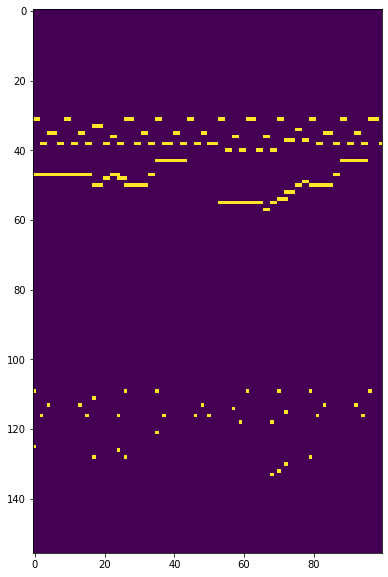

In [13]:
plt.figure(figsize = (20,10))
plt.imshow(100*song[:100,:].T)

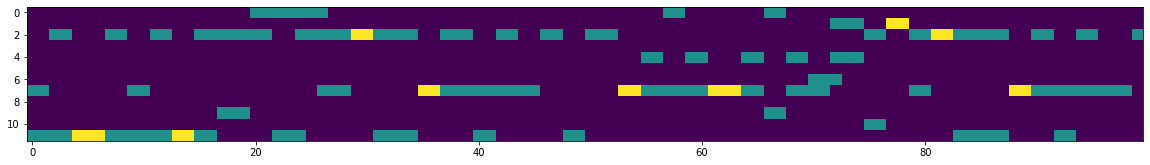

In [14]:
plt.figure(figsize = (20,10))
plt.imshow(100*chroma[:100,:].T)

##### Question 1 [10 points]
Describe what the chromas function does. In your answer refer to musical terms of note names and octave numbers. How does that resemble or differ from the chroma feature that is computed for audio spectrum? Use the figures to demonstrate the explanation.

Hint: Refresh the musical terms by looking at the lecture slides and consider what type of music anaylsis the audio chroma is used for. If you are interested more in musical theory you may also consider the concepts of "pitch class" and "music set theory" that are explained in https://en.wikipedia.org/wiki/Musical_note and https://en.wikipedia.org/wiki/Set_theory_%28music%29

**The function "add_chromas" is intended to calculate the chroma features for a set of songs stored in the dictionary. After the calculation of the chroma feature for each song, the code adds the "chroma" matrix as an additional field to the corresponding song in the "songs" dictionary, with the key being "chroma".<br><br>The concept of chroma and pitch class in music refers to the way that different musical pitches are perceived and grouped based on their similarity in color. The idea is that two musical pitches are seen as similar in color if they are an octave apart. The chroma component represents the note name (e.g. C, C#, D, D#, etc.) and a pitch class is defined as a set of pitches that share the same chroma. This means that each pitch class is the set of all pitches of a certain note across all octaves.<br><br>Chroma features provide a compact representation of musical structure and are useful for tasks such as genre classification and key detection, while differing from audio spectrum representations which provide a more general description of sound representing the overall spectral content of a piece of music, not just the distribution of pitches.<br><br>The musical notation representation can be seen in the above figure, where in the chroma matrix the columns represent a time step corresponds to a fixed unit of time, and each row represent a different pitch class**

# 2. Setting Up GAN Model

In [15]:
lowest_note = 0 #the index of the lowest note on the piano roll
highest_note = 78 #the index of the highest note on the piano roll
note_range = highest_note-lowest_note #the note range

num_timesteps  = 4 #This is the number of timesteps that we will create at a time
X_dim = 2*note_range*num_timesteps #This is the size of the visible layer. 
Z_dim = 12*num_timesteps
n_hidden = 50 #This is the size of the hidden layer

print(X_dim,Z_dim)

624 48


##### Question 2 [10 points]

Explain what aspects of music (pitch, rhythm, note duration) are captured by the latent random Z? In your answer refer to the representaiton of the song data. Note how song matrix differs from standard pianoroll.

**The representation of song data in the computations is different from the standard pianoroll representation. The standard pianoroll is a matrix of pitches by timesteps, where each row represents a pitch and each column represents a moment in time. The song matrix, on the other hand, only captures half of the pitches but also includes the rhythm explicitly, with each column representing a moment in time and the first half of the rows representing the signal of the main pitches and the last half representing the rhythm of those pitches.<br><br>The latent random variable Z captures some aspects of music, including pitch, rhythm, and note duration. Z is a vector of pitch classes by timesteps, where the magnitude of each note or pitch class at each moment in time represents the pitch. The rhythm and note duration can be captured by the sequence of a specific note or pitch class over time.**

In [16]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [17]:
tf.disable_v2_behavior()

#setting up model, discriminator weights and biases
X = tf.placeholder(tf.float32, shape=[None, X_dim])


D_W1 = tf.Variable(xavier_init([X_dim+Z_dim, 512]))
D_b1 = tf.Variable(tf.zeros(shape=[512]))

D_W2 = tf.Variable(xavier_init([512, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

Instructions for updating:
non-resource variables are not supported in the long term


In [18]:
#setting up model, generator weights and biases

#z is the space we're generating from
Z = tf.placeholder(tf.float32, shape=[None, Z_dim])

G_W1 = tf.Variable(xavier_init([Z_dim, 128]))
G_b1 = tf.Variable(tf.zeros(shape=[128]))

G_W2 = tf.Variable(xavier_init([128, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

In [19]:
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob

In [20]:
def discriminator(x,c):
    D_h1 = tf.nn.relu(tf.matmul(tf.concat([x,c],1), D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit

In [21]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')

        plt.imshow(sample.reshape(78, 30), cmap='Greys_r')


    return fig

In [22]:
G_sample = generator(Z)

In [23]:
D_real, D_logit_real = discriminator(X,Z)

In [24]:
D_fake, D_logit_fake = discriminator(G_sample,Z)

##### Question 3 [10 points]
In standard GAN, the discriminator receives as input true or fake (generated) data only. Explain why in our case the disrciminator receives as input both the data and an additional variable Z? How this Z differs from the usual GAN input of a random vector?

**In a standard Generative Adversarial Network (GAN), the discriminator receives as input either real data from the training set or fake data generated by the generator. The purpose of the discriminator is to distinguish between the two inputs and guide the generator towards producing more realistic outputs.<br><br>In a Conditional GAN (cGAN), the discriminator also receives as input an additional variable, Z, which provides specific information about the desired texture or content of the audio. Z differs from the usual random vector input in a standard GAN, as it provides specific information about the desired output, rather than adding stochasticity.<br><br>By including Z as input to the discriminator, cGANs allow for a more controlled and specific audio generation process, as the generator has additional information about the desired output and the discriminator can more accurately evaluate the generated audio based on this information. This makes cGANs well suited for style transfer tasks that aim to change the musical texture of a piece while maintaining its harmonic structure.**

In [ ]:

# Alternative losses:
# -------------------
Lambda = 100
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))
G_loss_L1 = tf.reduce_mean(tf.losses.mean_squared_error(X,G_sample))
G_loss = G_loss_fake + Lambda*G_loss_L1

##### Question 4 [10 points]
Explain the two components of the discriminator loss in the D_loss expression. Why the real loss uses tf.ones_like andthe fake loss uses tf.zeros_like in the cross entory loss? What are the statistical distributions (which datasets are used) in computational of the real and fake losses. In your answers you may either include an equation image or write the loss equaiton in latex mathamtical notation inside Markdown cell.

**The discriminator loss, D_loss, is the sum of two components: the loss for evaluating the real data, and the loss for evaluating the generated data: $E_x[log(D(x))] + E_z[log(1 - D(G(z)))]$.<br><br>The first component of the loss, calculates the loss for the real data. The cross-entropy loss is used to measure the difference between the predicted probabilities (output of the discriminator) and the target probabilities. Here, D_logit_real is the logit output of the discriminator for the real data, and tf.ones_like(D_logit_real) is the label for this data, which represents the target probability that the input is real. The cross-entropy loss measures the error of the discriminator in assigning a high confidence that the input is real, with the target probability being 1 (perfect classification as real data).<br><br>The second component of the loss, calculates the loss for the generated data. Here, D_logit_fake is the logit output of the discriminator for the generated data, and tf.zeros_like(D_logit_fake) is the label for this data, which represents the target probability that the input is real. The cross-entropy loss measures the error of the discriminator in assigning a low confidence that the input is real, with the target probability being 0 (perfect classification as fake data).<br><br>Finally, on both losses, the tf.reduce_mean function calculates the average of the cross entropy loss over all the corresponding examples.<br><br>The real loss and fake loss are computed using different datasets, as the real loss uses real data and the fake loss uses generated data. The statistical distributions of these two datasets are different, as the real data comes from the training set, while the generated data is created by the generator, which can generate data from a different distribution than the real data.**

##### Question 5 [10 points]
In the generator loss G_loss we add an L1 loss. What does it represent? Why do you think we might want to add the L1 loss to the GAN model? We will explore this question further down the assignment, so at this point write down your best explanation based on the equations themselves without running any experiments.

**The L1 loss term serves to penalize the generator for producing outputs that are different from the target data, X. This L1 loss measures the mean absolute difference between the generated samples and the target data, and its addition to the generator loss function serves to improve the quality of the generated samples by ensuring that they are more similar to the target data. The objective of this regularization term is to encourage the generator to produce outputs that are more closely aligned with the target data distribution, resulting in improved performance and stability of the GAN model.**

In [ ]:
#optimizing functions
D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

In [ ]:
#output midi file folder
if not os.path.exists('out/'):
    os.makedirs('out/')

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# 3. Training GAN Model

In [ ]:
i = 0
num_epochs = 200000
batch_size = 100
S_cutoff = 0.5
#commented out print statements output different losses, and plotting functions plot the piano roll and chroma.
while i <= num_epochs:
    # for song, chroma in zip(songs, chromas):      
    for files in songs:
        song = songs[files]['song']
        chroma = songs[files]['chroma']
        # The songs are stored in a time x notes format. The size of each song is timesteps_in_song x 2*note_range
        # Here we reshape the songs so that each training example is a vector with num_timesteps x 2*note_range elements    
        song = np.array(song)     
        song_steps = np.floor(song.shape[0]/num_timesteps).astype(int)
        song = song[:song_steps*num_timesteps]
        song = np.reshape(song, [song_steps, song.shape[1]*num_timesteps])  
        chroma = np.array(chroma)
        chroma = chroma[:song_steps*num_timesteps]
        chroma = np.reshape(chroma, [song_steps, chroma.shape[1]*num_timesteps])                
        batch_size = min(batch_size,len(song))
        # Train the RBM on batch_size examples at a time
        for ind in range(0, len(song), batch_size):       
            X_mb = song[ind:ind+batch_size]
            ch = chroma[ind:ind+batch_size]
            _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: ch})
            _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={X: X_mb, Z: ch})
    
            if i % 1000 == 0:
                print('Iter: {}'.format(i))
                dloss = ('D_Loss: {:.4}'. format(D_loss_curr))
                gloss = ('G_Loss: {:.4}'. format(G_loss_curr))
                print(dloss)
                print(gloss)
                
                samples = sess.run(G_sample, feed_dict={Z: ch})
        
                S = np.reshape(samples, (ch.shape[0]*num_timesteps, 2*note_range))
                thresh_S = S>=S_cutoff

                thresh_S = np.transpose(thresh_S)


                C = np.reshape(ch, (ch.shape[0]*num_timesteps, 12))

                test = reverse_pianoroll.piano_roll_to_pretty_midi(convert.back(thresh_S), fs=16)
                test.write('out/{}.mid'.format(i))

            i += 1

Iter: 0
D_Loss: 1.202
G_Loss: 32.03
Iter: 1000
D_Loss: 0.006248
G_Loss: 12.33
Iter: 2000
D_Loss: 0.1429
G_Loss: 5.196
Iter: 3000
D_Loss: 0.0003447
G_Loss: 14.44
Iter: 4000
D_Loss: 0.0005084
G_Loss: 17.29
Iter: 5000
D_Loss: 0.001633
G_Loss: 11.86
Iter: 6000
D_Loss: 0.001723
G_Loss: 15.86
Iter: 7000
D_Loss: 8.033e-05
G_Loss: 17.3
Iter: 8000
D_Loss: 4.72e-06
G_Loss: 20.22
Iter: 9000
D_Loss: 1.031e-05
G_Loss: 19.46
Iter: 10000
D_Loss: 2.045e-05
G_Loss: 19.4
Iter: 11000
D_Loss: 1.994e-05
G_Loss: 21.07
Iter: 12000
D_Loss: 1.308e-06
G_Loss: 30.05
Iter: 13000
D_Loss: 4.233e-07
G_Loss: 25.67
Iter: 14000
D_Loss: 1.858e-07
G_Loss: 27.22
Iter: 15000
D_Loss: 2.525e-06
G_Loss: 33.75
Iter: 16000
D_Loss: 7.342e-06
G_Loss: 26.87
Iter: 17000
D_Loss: 4.783e-07
G_Loss: 23.58
Iter: 18000
D_Loss: 3.079e-07
G_Loss: 30.77
Iter: 19000
D_Loss: 4.848e-08
G_Loss: 37.25
Iter: 20000
D_Loss: 4.753e-08
G_Loss: 35.09
Iter: 21000
D_Loss: 1.489e-07
G_Loss: 43.93
Iter: 22000
D_Loss: 1.68e-08
G_Loss: 43.73
Iter: 23000
D_L

# 4. Style Transfer with a New Genre Dataset

In this part we will explore using the trained GAN to compose new music according to the harmonic structure of another musical input. In a way this comprises of a style transfer between the input music that belongs to style A and the output music that is generated using GAN trained on style B. In the example we will used J.S.Bach as our input (Style A) and output music in Mozart's style that was use to train our GAN (Style B). The new Mozart piece should follow the harmonic structure (chord progressions) of the Bach input.

In [ ]:
#for testing, we will be using a different composer dataset to input into the generator here.
test_song = get_songs("./Classical_Music_Midi/bach")
test_song = add_chromas(test_song)

print ("{} songs processed".format(len(['song' in test_song[f] for f in test_song])))
print ("{} chromas processed".format(len(['chroma' in test_song[f] for f in test_song])))

3 songs processed
3 chromas processed


In [ ]:
#converted midi file folder
if not os.path.exists('converted/'):
    os.makedirs('converted/')

In [ ]:
i = 0
S_cutoff = 0.5

# for i,c in enumerate(test_chromaz):
for song in test_song:
    test_chroma = np.array(test_song[song]['chroma'])
    
    test_chroma = test_chroma[:np.floor(test_chroma.shape[0]/num_timesteps).astype(int)*num_timesteps]
    test_chroma = np.reshape(test_chroma, [int(test_chroma.shape[0]/num_timesteps), test_chroma.shape[1]*num_timesteps])
       
    out_samples = sess.run(G_sample, feed_dict={Z: test_chroma})
    
    S = np.reshape(out_samples, (np.floor(out_samples.shape[0]*out_samples.shape[1]/2/note_range).astype(int), 2*note_range))
    C = np.reshape(test_chroma, (test_chroma.shape[0]*num_timesteps, 12))

    thresh_S = S>=S_cutoff
    thresh_S = np.transpose(thresh_S)

    test = reverse_pianoroll.piano_roll_to_pretty_midi(convert.back(thresh_S), fs=16)
    test_song[song]['generated'] = test
    test.write('converted/{}.mid'.format(song.split('/')[-1].split('.')[0]+"generated"))



##### Question 6 [10 points]
Open the conversion results in a musical MIDI software (such as Musescore) and observe/listen to the results. Write down your impressions about the quality of the musical texture style transfer - did the harmonic structure follow the Bach input? How did the notes distribution (choice of pitches and durations) change relative to the original Bach piece? Does the S_cutoff parameter affect the outcome, and if so, how? 

Summarize your findings and suggest some conclusions. Can you point to any musical aspects that were poorly modeled and ideas of improvement? 

**The results of the conversion using a musical MIDI software, showed that the generator did not produce accurate pitches compared to the original input by Bach. However, it was able to generate notes with similar durations. The "S_cutoff" parameter can affect the outcome by cutting off low magnitude pitches to reduce noise.<br><br>The input to the generator was a flattened vector of chroma values, which has limitations in preserving the harmony and rhythm of the original piece. The number of time-steps and the choice of a flat vector representation instead of a sequence representation with RNNs could also be factors in the poor musical texture quality.<br><br>In summary, the generator was not able to accurately capture the harmony and pitches of the original Bach piece, which can be improved by using a more comprehensive input representation and by using RNNs to capture the timeliness of the piece.**

# 5. Further experiments

##### Question 7 & 8: [total 40 points]

Choose two of the experiments and report their results:

1. Explore style transfer between more distant styles: For this purpose you may use the Pop_Music_Midi dataset and repeat the Style Transfer Experiment between Classical and Pop music (and vice versa). Report your findings in qualitative ways and submit the midi results together with your explanation. [20 Points]

2. Expermment with L1 distance: retrain the GAN model with very small and very large Lambda. What are the effects of such changes? When is the texture of the output more or less musical? Are the harmonic progressions of the input followed or ignored? Any other observations? [20 Points]

3. Create your own song: use the leadsheet2chroma.py file provided to create a Mozart style composition from your own leadsheet input. Provide the leadsheet in text format and the midi file results. Report your observations about the musical quality of the results. You may alter the leadsheet2chroma.py to fit other chords if you wish, or train GAN in a style different then Mozart. [20 Points]



In [40]:
!unzip /content/Pop_Music_Midi.zip -d /content/

Archive:  /content/Pop_Music_Midi.zip
  inflating: /content/Pop_Music_Midi/All The Small Things - Chorus.midi  
  inflating: /content/Pop_Music_Midi/All The Small Things - Verse.midi  
  inflating: /content/Pop_Music_Midi/Around The World - Chorus.midi  
  inflating: /content/Pop_Music_Midi/Around The World - Verse.midi  
  inflating: /content/Pop_Music_Midi/Baby I_m Yours - Chorus.midi  
  inflating: /content/Pop_Music_Midi/Baby One More Time - Chorus.midi  
  inflating: /content/Pop_Music_Midi/Baby One More Time - Verse.midi  
  inflating: /content/Pop_Music_Midi/Barbie Girl - Chorus.midi  
  inflating: /content/Pop_Music_Midi/Barbie Girl - Verse.midi  
  inflating: /content/Pop_Music_Midi/Beautiful Life - Chorus.midi  
  inflating: /content/Pop_Music_Midi/Beautiful Life - Pre Chorus.midi  
  inflating: /content/Pop_Music_Midi/Beautiful Life - Verse.midi  
  inflating: /content/Pop_Music_Midi/Best Day Of My Life - Chorus.midi  
  inflating: /content/Pop_Music_Midi/Blank Space - Choru

In [173]:
def train(songs, lambda_value, output_path):
  G_sample = generator(Z)
  D_real, D_logit_real = discriminator(X,Z)
  D_fake, D_logit_fake = discriminator(G_sample,Z)

  Lambda = lambda_value
  D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
  D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
  D_loss = D_loss_real + D_loss_fake
  G_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))
  G_loss_L1 = tf.reduce_mean(tf.losses.mean_squared_error(X,G_sample))
  G_loss = G_loss_fake + Lambda*G_loss_L1

  D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
  G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

  if not os.path.exists(f'{output_path}/'):
      os.makedirs(f'{output_path}/')

  sess = tf.Session()
  sess.run(tf.global_variables_initializer())

  i = 0
  num_epochs = 10000
  batch_size = 100
  S_cutoff = 0.5

  while i <= num_epochs:

      for files in songs:
          song = songs[files]['song']
          chroma = songs[files]['chroma']

          song = np.array(song)     
          song_steps = np.floor(song.shape[0]/num_timesteps).astype(int)
          song = song[:song_steps*num_timesteps]
          song = np.reshape(song, [song_steps, song.shape[1]*num_timesteps])  
          chroma = np.array(chroma)
          chroma = chroma[:song_steps*num_timesteps]
          chroma = np.reshape(chroma, [song_steps, chroma.shape[1]*num_timesteps])                
          batch_size = min(batch_size,len(song))

          for ind in range(0, len(song), batch_size):       
              X_mb = song[ind:ind+batch_size]
              ch = chroma[ind:ind+batch_size]
              _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: ch})
              _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={X: X_mb, Z: ch})
      
              if i % 1000 == 0:
                  print('Iter: {}'.format(i))
                  dloss = ('D_Loss: {:.4}'. format(D_loss_curr))
                  gloss = ('G_Loss: {:.4}\n'. format(G_loss_curr))
                  print(dloss)
                  print(gloss)
                  
                  samples = sess.run(G_sample, feed_dict={Z: ch})
          
                  S = np.reshape(samples, (ch.shape[0]*num_timesteps, 2*note_range))
                  thresh_S = S>=S_cutoff

                  thresh_S = np.transpose(thresh_S)


                  C = np.reshape(ch, (ch.shape[0]*num_timesteps, 12))

                  test = reverse_pianoroll.piano_roll_to_pretty_midi(convert.back(thresh_S), fs=16)

              i += 1

  test.write(f'{output_path}/{output_path}_lambda_{lambda_value}.mid')
  return sess

In [174]:
def style_transfer(songs_path, sess):

  test_song = get_songs(songs_path)
  test_song = add_chromas(test_song)

  print ("{} songs processed".format(len(['song' in test_song[f] for f in test_song])))
  print ("{} chromas processed".format(len(['chroma' in test_song[f] for f in test_song])))

  if not os.path.exists(f'{songs_path}_converted/'):
      os.makedirs(f'{songs_path}_converted/')

  i = 0
  S_cutoff = 0.5

  for song in test_song:
      test_chroma = np.array(test_song[song]['chroma'])
      
      test_chroma = test_chroma[:np.floor(test_chroma.shape[0]/num_timesteps).astype(int)*num_timesteps]
      test_chroma = np.reshape(test_chroma, [int(test_chroma.shape[0]/num_timesteps), test_chroma.shape[1]*num_timesteps])
        
      out_samples = sess.run(G_sample, feed_dict={Z: test_chroma})
      
      S = np.reshape(out_samples, (np.floor(out_samples.shape[0]*out_samples.shape[1]/2/note_range).astype(int), 2*note_range))
      C = np.reshape(test_chroma, (test_chroma.shape[0]*num_timesteps, 12))

      thresh_S = S>=S_cutoff
      thresh_S = np.transpose(thresh_S)

      test = reverse_pianoroll.piano_roll_to_pretty_midi(convert.back(thresh_S), fs=16)
      test_song[song]['generated'] = test
      test.write('{}_converted/{}.mid'.format(songs_path, song.split('/')[-1].split('.')[0]+"_generated"))

In [175]:
def plot_songs(test_song):
  for cur_song in test_song.keys():
      file_name = cur_song.split('/')[-1].split('.')[0]
      song = test_song[cur_song]['song']

      plt.figure(figsize = (20,10))
      plt.title(f'{file_name}')
      plt.imshow(100*song[:100,:].T)

In [176]:
def plot_chromas(test_song):
  for cur_song in test_song.keys():
    file_name = cur_song.split('/')[-1].split('.')[0]
    chroma = test_song[cur_song]['chroma']

    plt.figure(figsize = (20,10))
    plt.title(f'{file_name}')
    plt.imshow(100*chroma[:100,:].T) 

## Style Transfer from Classical to Pop

In [177]:
songs = get_songs('./Pop_Music_Midi')
songs = add_chromas(songs)
print ("{} songs processed".format(len(['song' in songs[f] for f in songs])))
print ("{} chromas processed".format(len(['chroma' in songs[f] for f in songs])))

/usr/local/lib/python3.8/dist-packages/pretty_midi/pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


122 songs processed
122 chromas processed


In [178]:
lambda_value = 100
path = "classical_to_pop"

sess = train(songs, lambda_value, path)

Iter: 0
D_Loss: 1.024
G_Loss: 35.9

Iter: 1000
D_Loss: 0.1419
G_Loss: 9.833

Iter: 2000
D_Loss: 0.02599
G_Loss: 7.222

Iter: 3000
D_Loss: 0.006853
G_Loss: 8.689

Iter: 4000
D_Loss: 0.1264
G_Loss: 5.095

Iter: 5000
D_Loss: 0.07655
G_Loss: 19.33

Iter: 6000
D_Loss: 0.0001909
G_Loss: 14.51

Iter: 7000
D_Loss: 0.0005066
G_Loss: 10.91

Iter: 8000
D_Loss: 0.003088
G_Loss: 16.95

Iter: 9000
D_Loss: 0.0003066
G_Loss: 12.58

Iter: 10000
D_Loss: 1.054e-05
G_Loss: 15.22



In [179]:
source_path = './Classical_Music_Midi/bach'
style_transfer(source_path, sess)

3 songs processed
3 chromas processed


In [180]:
converted_style_songs = get_songs(f'{path}_converted')
converted_style_songs = add_chromas(converted_style_songs)

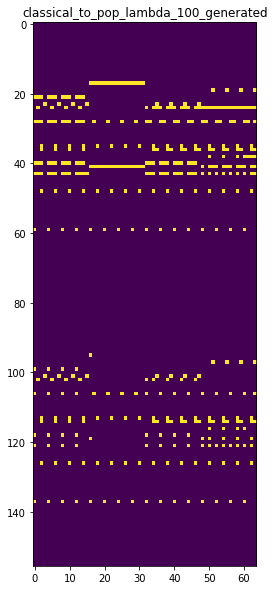

In [181]:
plot_songs(converted_style_songs)

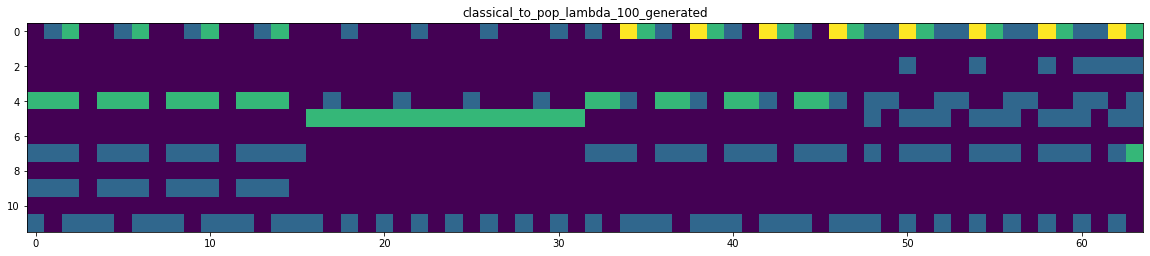

In [182]:
plot_chromas(converted_style_songs)

In [217]:
mid_path = '/content/classical_to_pop_converted/'    
files = glob.glob('{}/*.mid*'.format(mid_path))
for f in files:
  data = pretty_midi.PrettyMIDI(f)
display_audio(data)

## Style Transfer from Pop to Classical

In [183]:
songs = get_songs('./Classical_Music_Midi/bach')
songs = add_chromas(songs)
print ("{} songs processed".format(len(['song' in songs[f] for f in songs])))
print ("{} chromas processed".format(len(['chroma' in songs[f] for f in songs])))

3 songs processed
3 chromas processed


In [184]:
lambda_value = 100
path = "pop_to_classical"

sess = train(songs, lambda_value, path)

Iter: 0
D_Loss: 1.687
G_Loss: 30.18

Iter: 1000
D_Loss: 0.1072
G_Loss: 9.12

Iter: 2000
D_Loss: 0.09672
G_Loss: 6.484

Iter: 3000
D_Loss: 0.005961
G_Loss: 13.32

Iter: 4000
D_Loss: 0.009722
G_Loss: 13.44

Iter: 5000
D_Loss: 7.254e-05
G_Loss: 17.01

Iter: 6000
D_Loss: 0.0001052
G_Loss: 17.78

Iter: 7000
D_Loss: 0.0002623
G_Loss: 13.37

Iter: 8000
D_Loss: 2.894e-05
G_Loss: 16.57

Iter: 9000
D_Loss: 1.251e-06
G_Loss: 23.02

Iter: 10000
D_Loss: 2.375e-06
G_Loss: 24.89



In [185]:
source_path = './Pop_Music_Midi'
style_transfer(source_path, sess)

122 songs processed
122 chromas processed


In [186]:
converted_style_songs = get_songs(f'{path}_converted')
converted_style_songs = add_chromas(converted_style_songs)

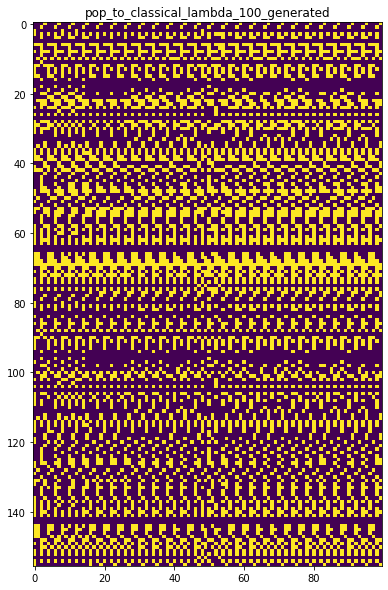

In [187]:
plot_songs(converted_style_songs)

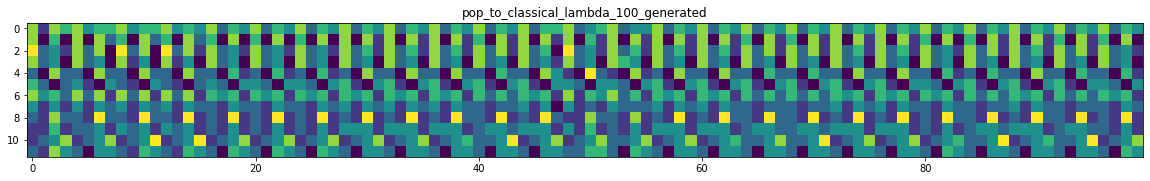

In [188]:
plot_chromas(converted_style_songs)

In [218]:
mid_path = '/content/pop_to_classical_converted/'    
files = glob.glob('{}/*.mid*'.format(mid_path))
for f in files:
  data = pretty_midi.PrettyMIDI(f)
display_audio(data)

**In our experiment, we attempted to perform style transfer between two distant styles: classical and pop music. As we can see from the chroma plots and the song matrix plots, it seems like the model struggled to transfer the style effectively, which might be solved if we further tune the hyperparameters, such as the value of lambda, let's check that in the next section:**

## L1 Distance Experiment - Bach to Mozart

In [189]:
songs = get_songs('./Classical_Music_Midi/mozart')
songs = add_chromas(songs)
print ("{} songs processed".format(len(['song' in songs[f] for f in songs])))
print ("{} chromas processed".format(len(['chroma' in songs[f] for f in songs])))

21 songs processed
21 chromas processed


In [190]:
lambda_value = 0.0001
path = "l1_distance"

sess = train(songs, lambda_value, path)

Iter: 0
D_Loss: 1.396
G_Loss: 4.05

Iter: 1000
D_Loss: 0.01715
G_Loss: 8.127

Iter: 2000
D_Loss: 0.0002609
G_Loss: 16.39

Iter: 3000
D_Loss: 0.002128
G_Loss: 12.64

Iter: 4000
D_Loss: 0.002058
G_Loss: 10.01

Iter: 5000
D_Loss: 0.0004198
G_Loss: 13.58

Iter: 6000
D_Loss: 7.731e-06
G_Loss: 14.85

Iter: 7000
D_Loss: 2.143e-05
G_Loss: 11.75

Iter: 8000
D_Loss: 9.018e-06
G_Loss: 16.06

Iter: 9000
D_Loss: 4.331e-06
G_Loss: 18.12

Iter: 10000
D_Loss: 5.286e-06
G_Loss: 14.52



In [192]:
lambda_value = 100
path = "l1_distance"

sess = train(songs, lambda_value, path)

Iter: 0
D_Loss: 1.695
G_Loss: 31.49

Iter: 1000
D_Loss: 0.4702
G_Loss: 4.794

Iter: 2000
D_Loss: 0.06415
G_Loss: 6.809

Iter: 3000
D_Loss: 0.01122
G_Loss: 11.09

Iter: 4000
D_Loss: 0.00591
G_Loss: 11.13

Iter: 5000
D_Loss: 0.0006084
G_Loss: 18.81

Iter: 6000
D_Loss: 8.386e-05
G_Loss: 18.56

Iter: 7000
D_Loss: 3.54e-05
G_Loss: 21.02

Iter: 8000
D_Loss: 2.753e-05
G_Loss: 17.85

Iter: 9000
D_Loss: 1.768e-05
G_Loss: 17.53

Iter: 10000
D_Loss: 1.121e-05
G_Loss: 20.91



In [193]:
lambda_value = 10000
path = "l1_distance"

sess = train(songs, lambda_value, path)

Iter: 0
D_Loss: 1.472
G_Loss: 2.746e+03

Iter: 1000
D_Loss: 0.02837
G_Loss: 166.0

Iter: 2000
D_Loss: 0.002929
G_Loss: 148.7

Iter: 3000
D_Loss: 0.004964
G_Loss: 117.4

Iter: 4000
D_Loss: 0.005816
G_Loss: 114.5

Iter: 5000
D_Loss: 0.00739
G_Loss: 128.2

Iter: 6000
D_Loss: 0.002141
G_Loss: 104.8

Iter: 7000
D_Loss: 0.003104
G_Loss: 126.3

Iter: 8000
D_Loss: 0.003864
G_Loss: 114.3

Iter: 9000
D_Loss: 0.04679
G_Loss: 113.4

Iter: 10000
D_Loss: 0.0004568
G_Loss: 121.6



In [194]:
source_path = "./Classical_Music_Midi/bach"
style_transfer(source_path, sess)

3 songs processed
3 chromas processed


In [202]:
test_songs = get_songs(f'{path}')
test_songs = add_chromas(test_songs)

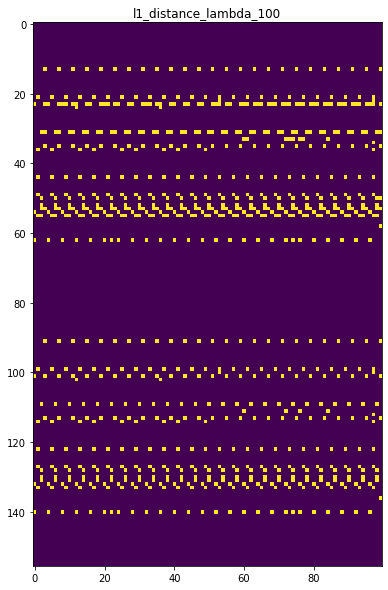

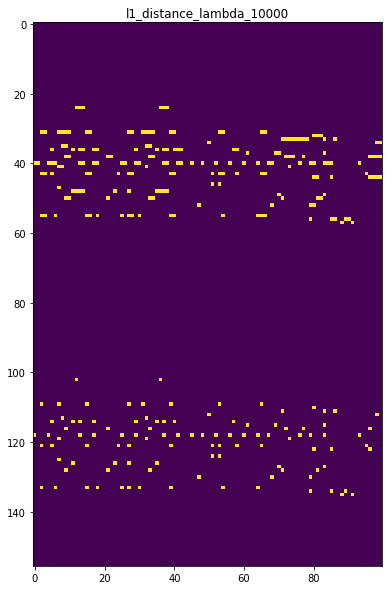

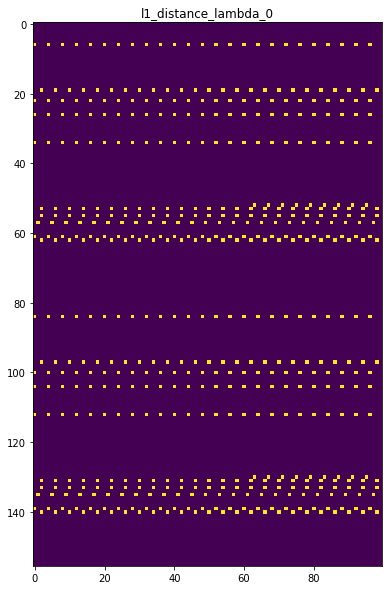

In [203]:
plot_songs(test_songs)

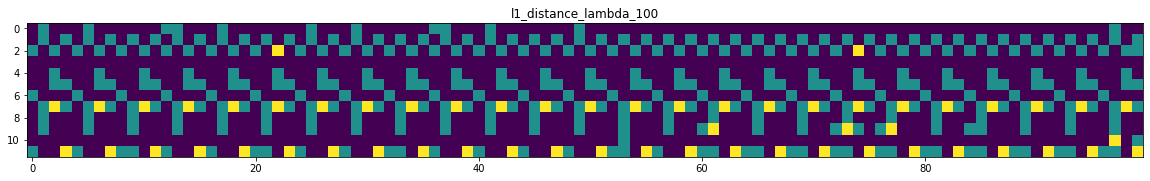

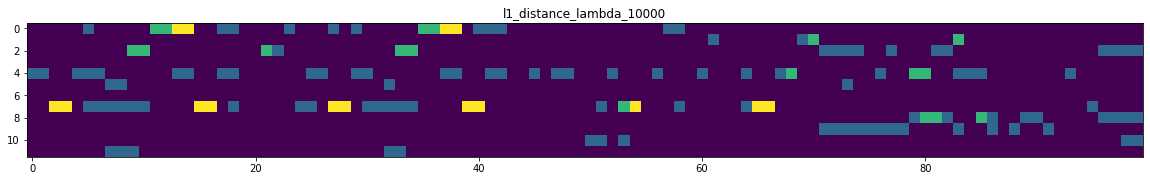

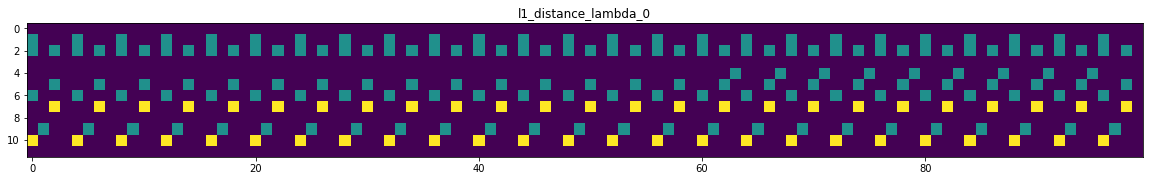

In [204]:
plot_chromas(test_songs)

**We experimented with L1 distance and changed the Lambda values for the GAN model. We observed the following:<br><br>When Lambda was set to 10000, the pieces generated followed the harmony progressions of the inputs, but their rhythm and note duration were different from the inputs. This happened because a higher Lambda of 10000 put more weight on capturing low-frequency details like pitch classes.<br><br>On the other hand, when Lambda was set to 0.0001, the pieces generated ignored the harmony progressions of the inputs. This happened because the model was trained with a lower weight for the L1 loss, meaning it was punished less for generating pieces that were far from the original inputs. This resulted in a less musical texture for the generated pieces.<br><br>In the chroma graphs, we can see that the pieces generated with Lambda=10000 were more similar to the original Bach pieces in terms of musical texture, while the pieces generated with Lambda=0.0001 were far from the original pieces.**